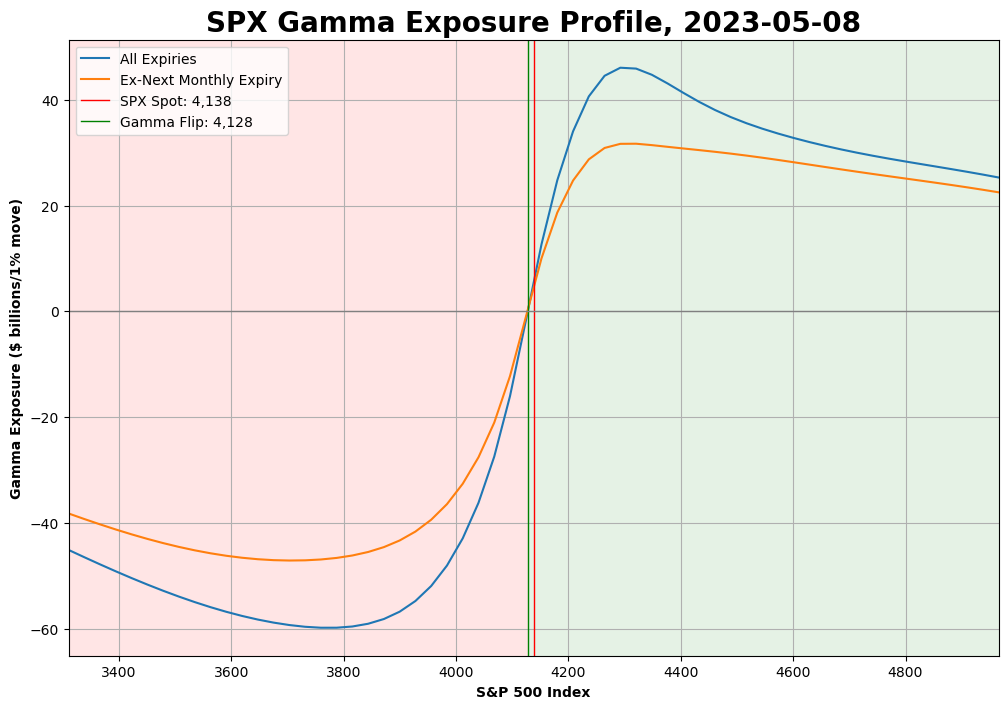

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import timedelta, date

def calcGammaEx(S, K, vol, T, OI, r=0, q=0):
    if T == 0 or vol == 0:
        return 0

    d1 = (np.log(S/K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * vol * np.sqrt(T))
    gamma_exposure = OI * 100 * S * S * 0.01 * gamma 
    
    return gamma_exposure

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

filename = 'spx_quotedata.csv'
optionsFile = open(filename, 'rt', encoding='UTF8')
optionsFileData = optionsFile.readlines()
optionsFile.close()

spotLine = optionsFileData[1]
spotPrice = float(spotLine.split(',')[1].split(' ')[1])
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(',')
monthDay = todayDate[0].split(' ')

year = int(monthDay[0][:-1])
month = int(monthDay[1][:-1])
day = int(monthDay[2][:-1])
todayDate = date(year, month, day)

df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'], format='%a %b %d %Y')
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['CallIV'] = df['CallIV'].astype(float)
df['PutIV'] = df['PutIV'].astype(float)
df['CallGamma'] = df['CallGamma'].astype(float)
df['PutGamma'] = df['PutGamma'].astype(float)
df['CallOpenInt'] = df['CallOpenInt'].astype(float)
df['PutOpenInt'] = df['PutOpenInt'].astype(float)

df['daysTillExp'] = [np.busday_count(todayDate, x.date())/252 for x in df.ExpirationDate]
df['IsThirdFriday'] = [isThirdFriday(x) for x in df.ExpirationDate]

levels = np.linspace(fromStrike, toStrike, 60)

thirdFridays = df.loc[df['IsThirdFriday'] == True]
nextMonthlyExp = thirdFridays['ExpirationDate'].min()

totalGamma = []
totalGammaExFri = []

for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, 
                                                          row['StrikePrice'],
                                                          row['CallIV'], 
                                                          row['daysTillExp'], 
                                                          row['CallOpenInt']),
                                 axis=1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, 
                                                         row['StrikePrice'], 
                                                         row['PutIV'], 
                                                         row['daysTillExp'],
                                                         row['PutOpenInt']),
                                axis=1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

    exFri = df.loc[df['ExpirationDate'] != nextMonthlyExp]
    totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

totalGamma = np.array(totalGamma) / 1e9
totalGammaExFri = np.array(totalGammaExFri) / 1e9

zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

zeroGamma = (posStrike - ((posStrike - negStrike) * posGamma / (posGamma - negGamma)))[0]

fig, ax = plt.subplots(figsize=(12, 8))
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
chartTitle = "SPX Gamma Exposure Profile, " + todayDate.strftime('%Y-%m-%d')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('S&P 500 Index', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="SPX Spot: " + str("{:,.0f}".format(spotPrice)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([fromStrike, toStrike])
trans = ax.get_xaxis_transform()
plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
plt.legend()
plt.show()

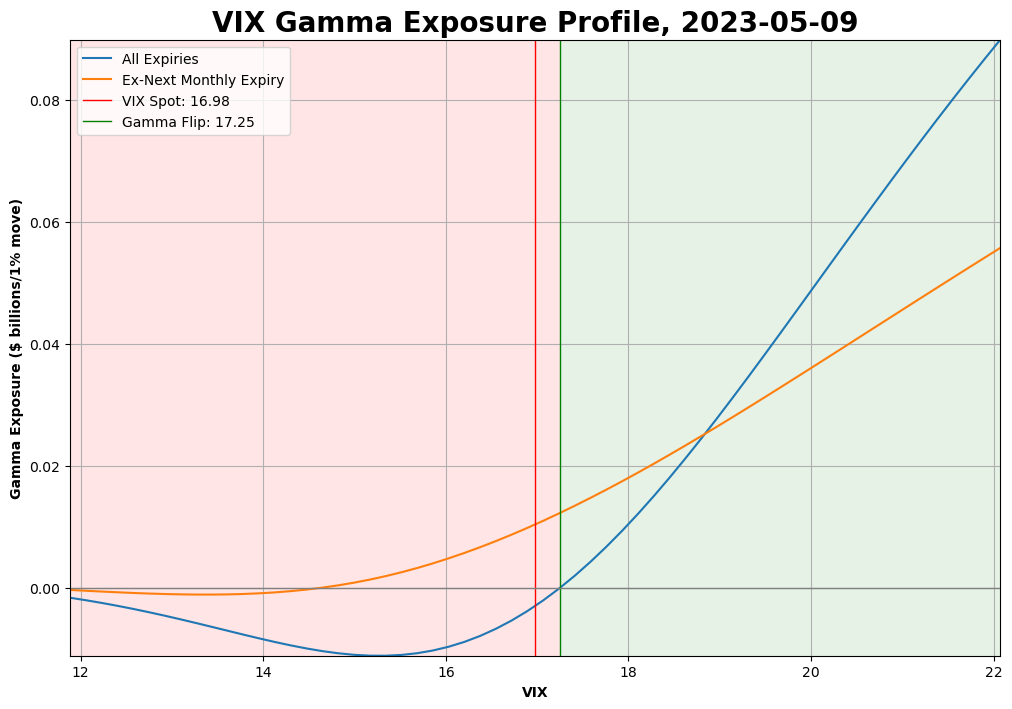

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import timedelta, date

def calcGammaEx(S, K, vol, T, OI, r=0, q=0):
    if T == 0 or vol == 0:
        return 0

    d1 = (np.log(S/K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * vol * np.sqrt(T))
    gamma_exposure = OI * 100 * S * S * 0.01 * gamma 
    
    return gamma_exposure

def isThirdWednesday(d):
    return d.weekday() == 2 and 15 <= d.day <= 21

filename = 'vix_quotedata.csv'
optionsFile = open(filename, 'rt', encoding='UTF8')
optionsFileData = optionsFile.readlines()
optionsFile.close()

spotLine = optionsFileData[1]
spotPrice = float(spotLine.split(',')[1].split(' ')[1])
fromStrike = 0.7 * spotPrice
toStrike = 1.3 * spotPrice

dateLine = optionsFileData[2]
todayDate = dateLine.split('Date: ')[1].split(',')
monthDay = todayDate[0].split(' ')

year = int(monthDay[0][:-1])
month = int(monthDay[1][:-1])
day = int(monthDay[2][:-1])
todayDate = date(year, month, day)

df = pd.read_csv(filename, sep=",", header=None, skiprows=4)
df.columns = ['ExpirationDate','Calls','CallLastSale','CallNet','CallBid','CallAsk','CallVol',
              'CallIV','CallDelta','CallGamma','CallOpenInt','StrikePrice','Puts','PutLastSale',
              'PutNet','PutBid','PutAsk','PutVol','PutIV','PutDelta','PutGamma','PutOpenInt']

df['ExpirationDate'] = pd.to_datetime(df['ExpirationDate'], format='%a %b %d %Y')
df['StrikePrice'] = df['StrikePrice'].astype(float)
df['CallIV'] = df['CallIV'].astype(float)
df['PutIV'] = df['PutIV'].astype(float)
df['CallGamma'] = df['CallGamma'].astype(float)
df['PutGamma'] = df['PutGamma'].astype(float)
df['CallOpenInt'] = df['CallOpenInt'].astype(float)
df['PutOpenInt'] = df['PutOpenInt'].astype(float)

df['daysTillExp'] = [np.busday_count(todayDate, x.date())/252 for x in df.ExpirationDate]
df['IsThirdWednesday'] = [isThirdWednesday(x) for x in df.ExpirationDate]

levels = np.linspace(fromStrike, toStrike, 60)

thirdWednesdays = df.loc[df['IsThirdWednesday'] == True]
nextMonthlyExp = thirdWednesdays['ExpirationDate'].min()

totalGamma = []
totalGammaExWed = []

for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, 
                                                          row['StrikePrice'],
                                                          row['CallIV'], 
                                                          row['daysTillExp'], 
                                                          row['CallOpenInt']),
                                 axis=1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, 
                                                         row['StrikePrice'], 
                                                         row['PutIV'], 
                                                         row['daysTillExp'],
                                                         row['PutOpenInt']),
                                axis=1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

    exWed = df.loc[df['ExpirationDate'] != nextMonthlyExp]
    totalGammaExWed.append(exWed['callGammaEx'].sum() - exWed['putGammaEx'].sum())

totalGamma = np.array(totalGamma) / 1e9
totalGammaExWed = np.array(totalGammaExWed) / 1e9

zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

zeroGamma = (posStrike - ((posStrike - negStrike) * posGamma / (posGamma - negGamma)))[0]

fig, ax = plt.subplots(figsize=(12, 8))
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
plt.plot(levels, totalGammaExWed, label="Ex-Next Monthly Expiry")
chartTitle = "VIX Gamma Exposure Profile, " + todayDate.strftime('%Y-%m-%d')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('VIX', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="VIX Spot: " + str("{:,.2f}".format(spotPrice)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.2f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([fromStrike, toStrike])
plt.ylim([min(totalGamma), max(totalGamma)])
trans = ax.get_xaxis_transform()
plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1)
plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1)
plt.legend()
plt.show()